# Assessment 2: CNNs for image classification

In [45]:
## Data manioulation
import pandas as pd
import numpy as np
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## NN
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from fastai.vision.all import *

In [42]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


## Step01: Data exploration

In [54]:
## Download from cifar10
training_data = datasets.FGVCAircraft(
    root="data",
    split = 'train',
    annotation_level = 'family',
    download = True,
    transform= transforms.ToTensor()
)

test_data = datasets.FGVCAircraft(
    root="data",
    split = 'test',
    annotation_level = 'family',
    download = True,
    transform= transforms.ToTensor()
)

### Exploratory Image analysis

In [73]:
## check shape and labels
img, label = training_data[3]
print(img.shape,label)

torch.Size([3, 678, 1000]) 12


Label : Boeing 707


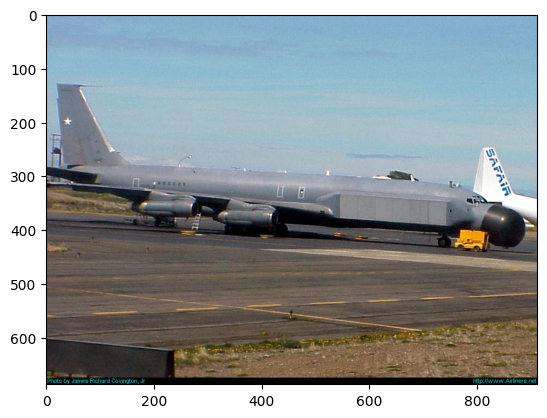

In [68]:
def display_img(img,label):
  print(f"Label : {training_data.classes[label]}")
  plt.imshow(img.permute(1,2,0)) # for visualization following the plt need to change the shapes

#display the first image in the dataset
display_img(*training_data[2])

In [78]:
batch_size = 128
## apply the dataloader
torch.manual_seed(0)
trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory = True
    )

testloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory = True
    )

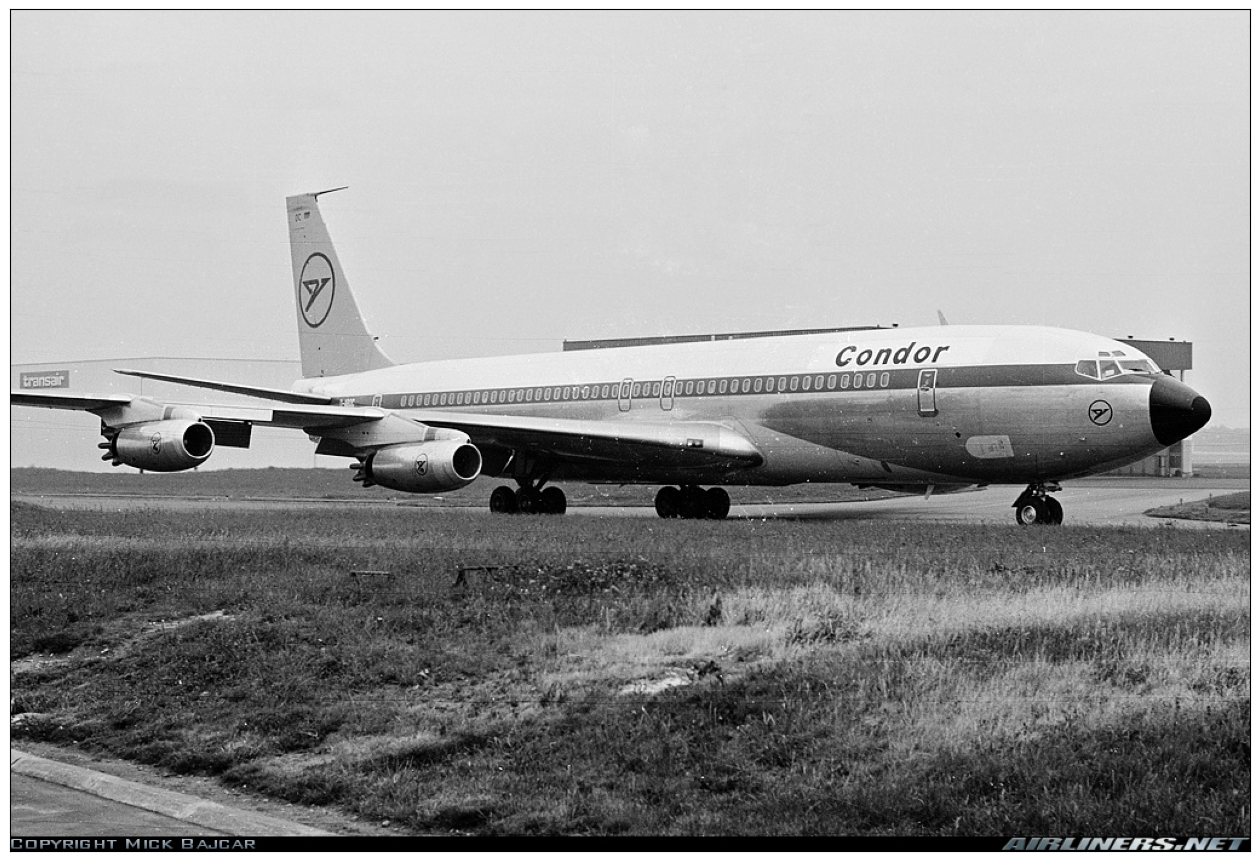

In [79]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

show_batch(training_data)

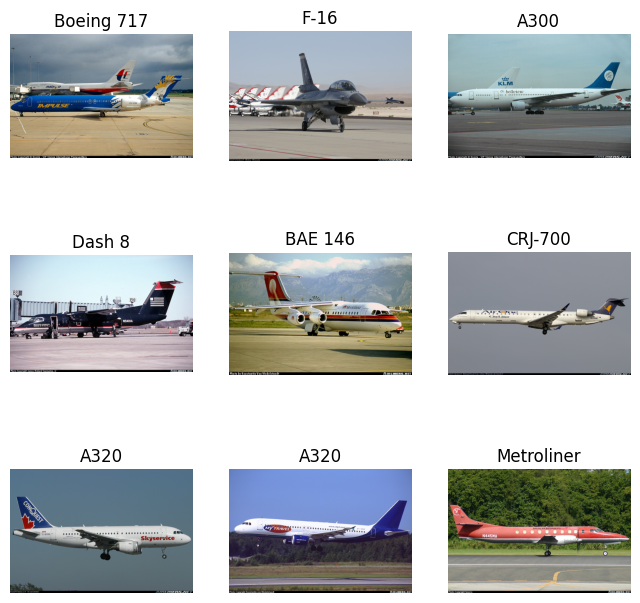

In [71]:
labels_map = { i:j for i,j in enumerate(training_data.classes)}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
torch.manual_seed(0)
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()

### Calculation function

In [ ]:
# Defining functions for getting accuracy and training the network.
def get_accuracy(pred_arr, original_arr):
    pred_arr = (pred_arr >= 0.5).float()*2 - 1  # Convert probabilities to binary predictions
    correct = (pred_arr == original_arr).float().sum()
    return (correct / original_arr.numel()) * 100  # use numel to get the number of elements in the tensor

def train_network(model, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs):
    train_loss=[]
    train_accuracy=[]
    test_accuracy=[]

    for epoch in range(num_epochs):
        #forward feed
        output_train = model(X_train)
        train_accuracy.append(get_accuracy(output_train, y_train))
        #calculate the loss
        loss = criterion(output_train, y_train)
        train_loss.append(loss.item())

        #clear out the gradients from the last step loss.backward()
        optimizer.zero_grad()

        #backward propagation: calculate gradients
        loss.backward()

        #update the weights
        optimizer.step()

        with torch.no_grad():
            output_test = model(X_test)
            # print(output_test,y_test)
            test_accuracy.append(get_accuracy(output_test, y_test))

        if (epoch + 1) % 100 == 0:
            # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Train Accuracy: {sum(train_accuracy)/len(train_accuracy):.2f}, Test Accuracy: {sum(test_accuracy)/len(test_accuracy):.2f}")
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy[-1]:.2f}, Test Accuracy: {test_accuracy[-1]:.2f}")

    return train_loss, train_accuracy, test_accuracy


def plot_performance_loss(metric):

    df = pd.DataFrame(dict(
        epoch = [i+1 for i in range(len(metric[0]))],
        train_loss = metric[0],
        train_accuracy = [ float(i) for i in metric[1] ],
        test_accuracy = [ float(i) for i in metric[2] ]
    ))

    plt.figure()
    plt.plot(df['epoch'], df['train_loss'])

    plt.xlabel("Epoch")
    plt.ylabel("Binary Loss")
    # plt.title("With Labels")
    plt.show()

def plot_performance_accuracy(metric):

    df = pd.DataFrame(dict(
        epoch = [i+1 for i in range(len(metric[0]))],
        train_loss = metric[0],
        train_accuracy = [ float(i) for i in metric[1] ],
        test_accuracy = [ float(i) for i in metric[2] ]
    ))

    plt.figure()
    plt.plot(df['epoch'], df['train_accuracy'])
    plt.plot(df['epoch'], df['test_accuracy'],
         color='red',
         linewidth=1.0,
         linestyle='--'
        )

    plt.xlabel("Epoch")
    plt.ylabel("Binary Loss")
    # plt.title("With Labels")
    plt.show()

## Initialize network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

net = Net()
print(net)
print(simple_net)

## Loss and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
epoch_num = 2
for epoch in range(epoch_num):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = simple_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Testing data

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(2)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))